In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad

In [2]:
import phylovelo as pv
from tqdm.autonotebook import tqdm

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [22]:
# from scipy.io import mmread
# count = mmread(data_path + 'GSE119945_gene_count.txt').T.tocsr().astype('float32')
# sample = np.random.choice(range(annotate_cell.shape[0]), 5000, replace=False)
# count1 = count[sample]
# count1 = pd.DataFrame(count1.A, index=annotate_cell.iloc[sample].index, columns=annotate_gene['gene_short_name'].to_numpy())
# time = annotate_cell.iloc[sample]['day'].to_numpy()
# xdr = annotate_cell.iloc[sample][['tsne_1', 'tsne_2']]

In [4]:
data_path = '/data3/wangkun/cao_mouse/'

In [6]:
annotate_cell = pd.read_csv(data_path + 'cell_annotate.csv', index_col=0)
annotate_gene = pd.read_csv(data_path + 'GSE119945_gene_annotate.csv', index_col=0)

In [8]:
count = pd.read_csv(data_path + 'gene_count_cleaned_sampled_100k.csv', index_col=0).T

In [21]:
sel_cells = np.random.choice(count.index, 10000, replace=False)

In [22]:
sel_count = count.loc[sel_cells]
annotate_cell = annotate_cell.loc[sel_cells]

In [32]:
sd = pv.scData(count=sel_count, cell_states=annotate_cell['Main_cell_type'].to_numpy(), Xdr=annotate_cell[['Main_cluster_tsne_1', 'Main_cluster_tsne_2']])

In [40]:
colors = ['#5D8AA8','#F0F8FF','#E32636','#E52B50','#FFBF00','#A4C639','#8DB600','#FBCEB1','#7FFFD4','#4B5320','#3B444B','#E9D66B','#B2BEB5','#87A96B','#FF9966','#6D351A','#007FFF','#89CFF0','#A1CAF1','#F4C2C2','#FFD12A','#848482','#98777B','#F5F5DC','#3D2B1F','#000000','#318CE7','#FAF0BE','#0000FF','#DE5D83','#79443B','#CC0000','#B5A642','#66FF00','#BF94E4','#C32148','#FF007F','#08E8DE','#D19FE8','#004225','#CD7F32','#964B00','#FFC1CC','#E7FEFF','#F0DC82','#800020','#DEB887','#CC5500']

Text(0.5, 1.0, 'Embryo2')

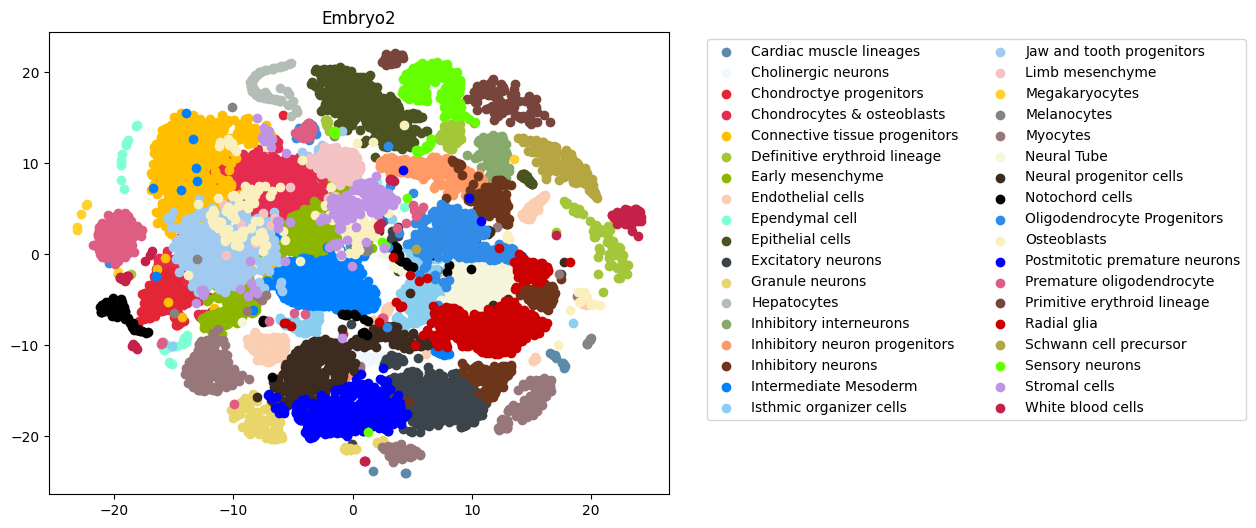

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
all_states = list(set(sd.cell_states))
all_states.sort()
for ind, i in enumerate(all_states):
    ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c=colors[ind], label=i)
# pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=1, lw_coef=8000, arrowsize=1.5)
ax.legend(ncol=2, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# label_name(sd.Xdr, [cell_state_map[i] for i in sd.cell_states], ax, font=font, fontsize=8)
ax.set_title('Embryo2')

In [52]:
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)

In [53]:
sd.count.columns = annotate_gene.loc[sd.count.columns]['gene_short_name'].to_numpy()

In [83]:
import anndata as ad
adata = ad.AnnData(sd.count)
sc.pp.filter_genes(adata, min_counts=100)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sd.x_normed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [84]:
sd.x_normed.shape

(10000, 9840)

In [85]:
vels_em2 = pd.read_csv('../megs/embryo2_all_mutnum.csv', index_col=0)
vels_em3 = pd.read_csv('../megs/embryo3_all_mutnum.csv', index_col=0)
vels_map = vels_em3.loc[set(vels_em2.index).intersection(set(vels_em3.index))]
vels = []
for i in sd.x_normed.columns:
    try:
        vels.append(vels_em3['velocity'][i])
    except:
        vels.append(0)
sd.velocity = np.array(vels)

/tmp/ipykernel_17081/1011092944.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  vels_map = vels_em3.loc[set(vels_em2.index).intersection(set(vels_em3.index))]


In [86]:
pv.velocity_embedding(sd, target='x_normed', n_neigh=800)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [76]:
from matplotlib import font_manager
import matplotlib.patheffects as pe

font = font_manager.FontProperties(fname='/data/public/font/arial/ARIALBD.TTF')
def label_name(loc, cell_types, ax, fontsize=12, font='DejaVu Sans'):
    loc = np.array(loc)
    cell_types = np.array(cell_types)
    for i in set(cell_types):
        loci = loc[cell_types==i].mean(0)
        ax.text(*loci, i, fontsize=fontsize, font=font,c='black', ha='center', va='center',
                path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    return ax
colors = ['#5D8AA8','#F0F8FF','#E32636','#E52B50','#FFBF00','#A4C639','#8DB600','#FBCEB1','#7FFFD4','#4B5320','#3B444B','#E9D66B','#B2BEB5','#87A96B','#FF9966','#6D351A','#007FFF','#89CFF0','#A1CAF1','#F4C2C2','#FFD12A','#848482','#98777B','#F5F5DC','#3D2B1F','#000000','#318CE7','#FAF0BE','#0000FF','#DE5D83','#79443B','#CC0000','#B5A642','#66FF00','#BF94E4','#C32148','#FF007F','#08E8DE','#D19FE8','#004225','#CD7F32','#964B00','#FFC1CC','#E7FEFF','#F0DC82','#800020','#DEB887','#CC5500']

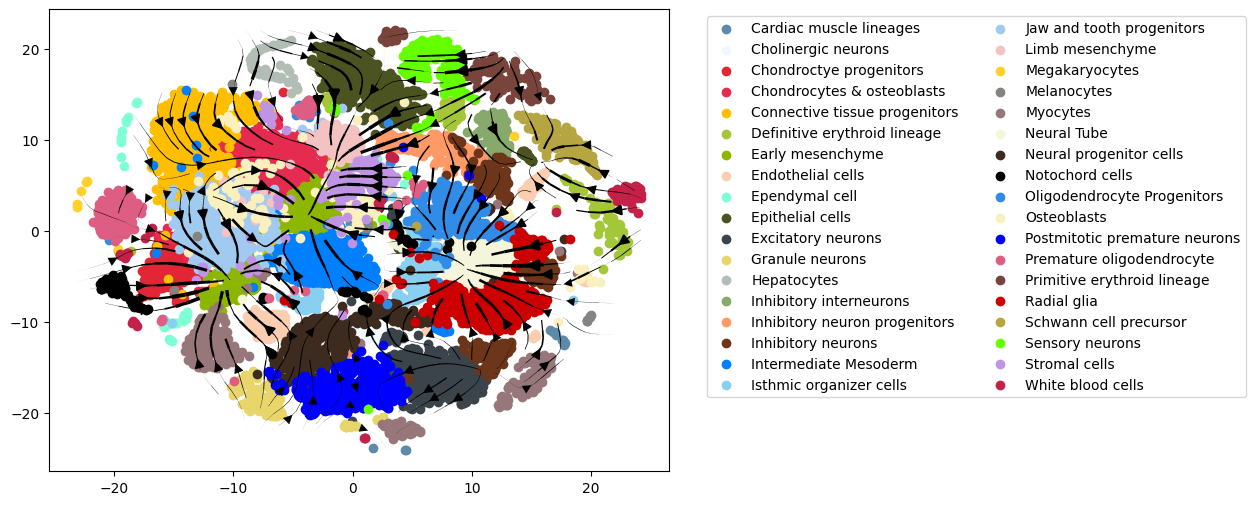

In [87]:
fig, ax = plt.subplots(figsize=(8,6))
all_states = list(set(sd.cell_states))
all_states.sort()
for ind, i in enumerate(all_states):
    ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c=colors[ind], label=i)
pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.5, grid_density=25, radius=0.8, lw_coef=50000, arrowsize=1.5)
ax.legend(ncol=2, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# label_name(sd.Xdr, sd.cell_states, ax, font=font, fontsize=8)
# ax.set_title('Embryo2')

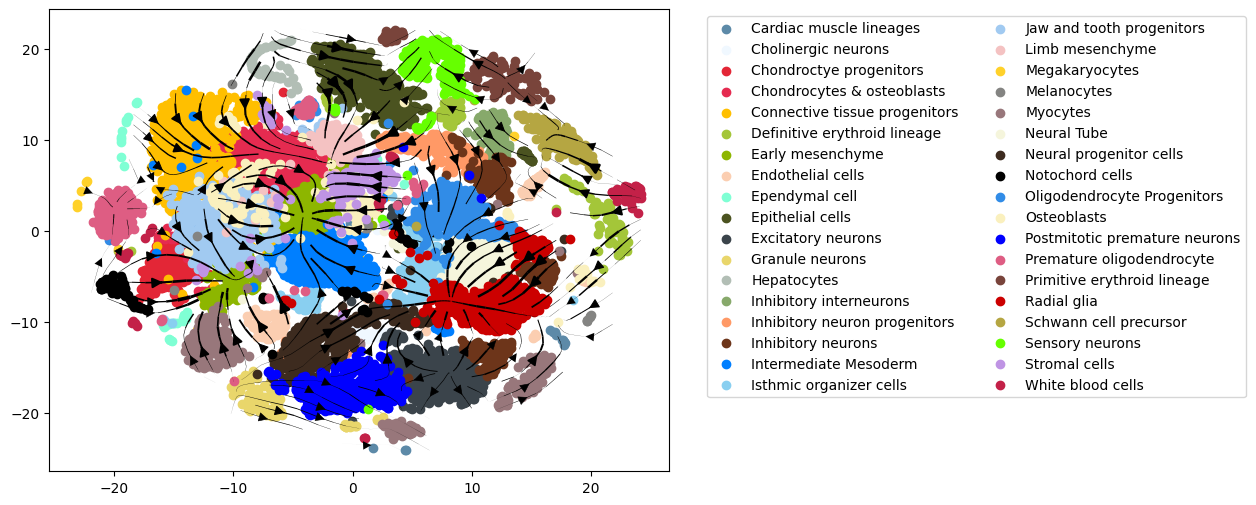

In [70]:
fig, ax = plt.subplots(figsize=(8,6))
all_states = list(set(sd.cell_states))
all_states.sort()
for ind, i in enumerate(all_states):
    ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c=colors[ind], label=i)
pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.5, grid_density=25, radius=0.8, lw_coef=80000, arrowsize=1.5)
ax.legend(ncol=2, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# ax.set_title('Embryo2')